# Backpropagation Through Time: A Regression Example

## What's new?
1. Implement an Elman RNN and the backpropagation through time (BPTT) algorithm using Numpy for a regression task.
2. Use L2-regularization / momentum update rather than the vanilla gradient descent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# This shows good pic: format from classic style; color and style from seaborn
plt.style.use('classic')
plt.style.use('seaborn')


# Hyper-Parameters
TIME_STEP = 10      # mini-batch size
SKIP = 10           # skip some time-steps to prepare hidden state in mini-batch training

INPUT_SIZE = 1      # RNN input size
HIDDEN_SIZE = 32    # RNN hidden size
OUTPUT_SIZE = 1     # RNN output size

LR = 1e-2           # learning rate
MM = 0.5            # momentum
REG = 1e-4          # regularization strength (L2)

## Data

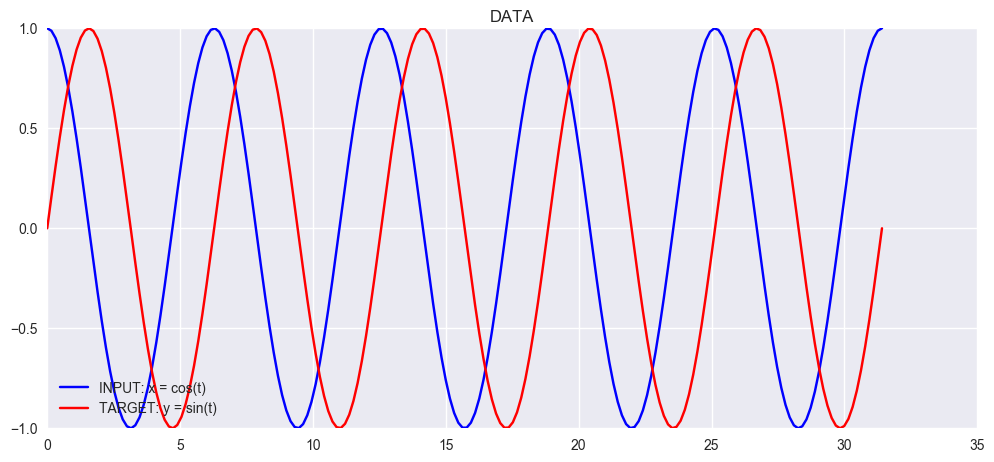

In [2]:
# Generate data: train a RNN to input cos(t) to predict sin(t)
N = 200
steps = np.linspace(0, 10* np.pi, N, dtype=np.float32)[:, np.newaxis]  # time steps
X = np.cos(steps)
y = np.sin(steps)


# Plot data
plt.figure(1, figsize=(12, 5))

plt.title('DATA')
plt.plot(steps, X, 'b', label='INPUT: x = cos(t)')
plt.plot(steps, y, 'r', label='TARGET: y = sin(t)')
plt.legend(loc='lower left')
plt.show()

## Model

In [3]:
# Hidden layer
Wh = np.random.randn(INPUT_SIZE, HIDDEN_SIZE)* np.sqrt(2.0/(INPUT_SIZE*HIDDEN_SIZE))
bh = np.zeros((1, HIDDEN_SIZE))  # input and recurrent layer share the same bias term

# Recurrent layer
Wr = np.random.randn(HIDDEN_SIZE, HIDDEN_SIZE)* np.sqrt(2.0/(HIDDEN_SIZE*HIDDEN_SIZE))

# Output layer
Wo = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE)* np.sqrt(2.0/(HIDDEN_SIZE*OUTPUT_SIZE))
bo = np.zeros((1, OUTPUT_SIZE))

## Plot

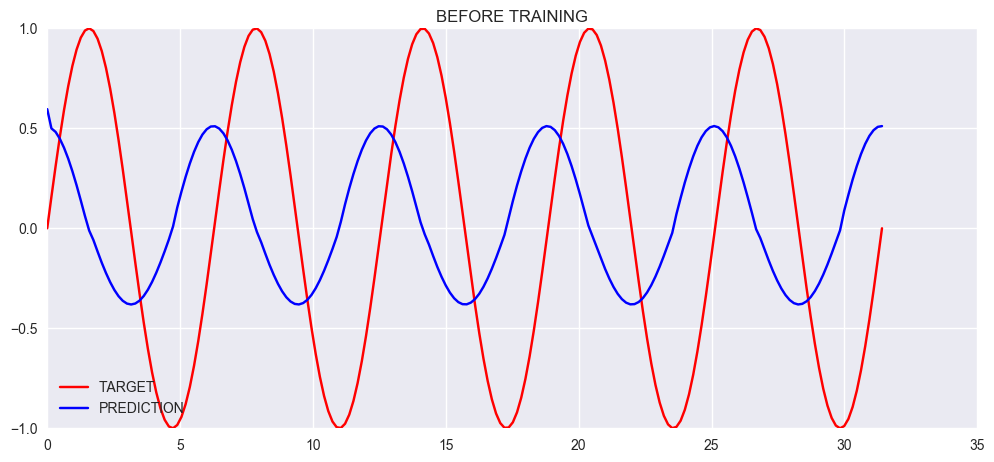

In [4]:
"""
Plot the result before training
"""

Ts = []
Ys = []
pred_lst = []


Ht = np.zeros((1, HIDDEN_SIZE))
for t in range(N):
    
    Xt = X[t:t+1]
    yt = y[t:t+1]
    
    #
    At = Xt.dot(Wh) + Ht.dot(Wr) + bh
    Ht  = np.maximum(At, 0)
    _yt = Ht.dot(Wo) + bo
    
    Ts.append(steps[t][0])
    Ys.append(yt[0][0])
    pred_lst.append(_yt[0][0])
    
    
# Plot
plt.figure(1, figsize=(12, 5))

plt.title('BEFORE TRAINING')
plt.plot(Ts, Ys, 'r', label='TARGET')
plt.plot(Ts, pred_lst, 'b', label='PREDICTION')
plt.legend(loc='lower left')

plt.show()

## Training

# Epoch: 99
Wh/dWh: 1.54 / 0.19
bh/dbh: 1.12 / 0.56
Wr/dWr: 1.74 / 0.88
Wo/dWo: 1.84 / 0.22
bo/dbo: 0.17 / 0.12



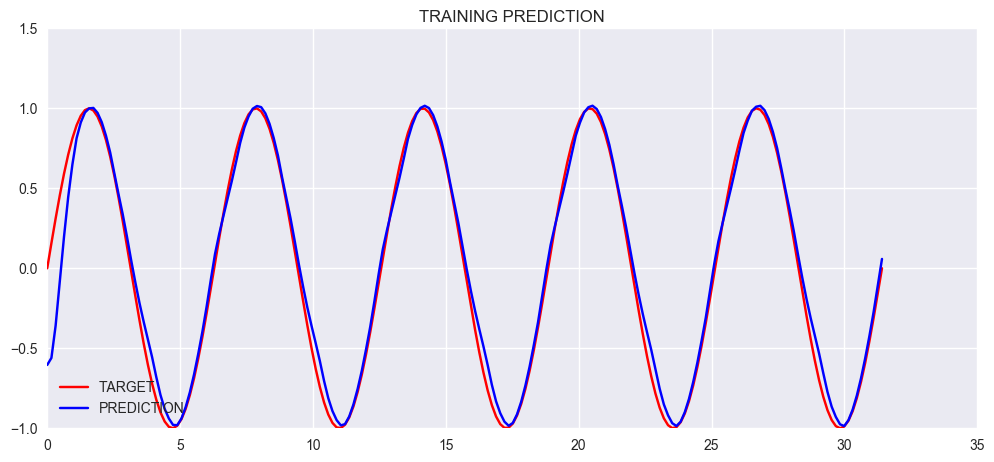

In [5]:
loss_lst = []

for epoch in range(100):
    
    vHt = np.zeros((1, HIDDEN_SIZE))
    vWh = np.zeros((INPUT_SIZE, HIDDEN_SIZE))
    vbh = np.zeros((1, HIDDEN_SIZE))
    vWr = np.zeros((HIDDEN_SIZE, HIDDEN_SIZE))
    vWo = np.zeros((HIDDEN_SIZE, OUTPUT_SIZE))
    vbo = np.zeros((1, OUTPUT_SIZE))

    
    for iteration in range(int(N/TIME_STEP)):
        # Initialize hidden state, gradients and lists
        Ht = np.zeros((1, HIDDEN_SIZE))

        dHt = np.zeros((1, HIDDEN_SIZE))
        dWh = np.zeros((INPUT_SIZE, HIDDEN_SIZE))
        dbh = np.zeros((1, HIDDEN_SIZE))
        dWr = np.zeros((HIDDEN_SIZE, HIDDEN_SIZE))
        dWo = np.zeros((HIDDEN_SIZE, OUTPUT_SIZE))
        dbo = np.zeros((1, OUTPUT_SIZE))

        Ht_lst = []; Ht_lst.append(Ht)
        At_lst = []
        _yt_lst = []


        """ Sample a mini-batch """
        start = np.random.randint(N)
        prestart = max(start - SKIP, 0)
        end = min(start + TIME_STEP, N)

        skipX = X[prestart:start, :]
        skipy = y[prestart:start, :]

        trainX = X[start:end, :]
        trainy = y[start:end, :]

        T = len(trainX)


        """ Forward Pass """
        # Prepare hidden state:
        #   Note we only need to forward propagate to the point where the hidden state is computed
        for t in range(len(skipX)):
            Xt = skipX[t:t+1]
            yt = skipy[t:t+1]

            At = Xt.dot(Wh) + Ht.dot(Wr) + bh
            Ht  = np.maximum(At, 0)


        # Training
        L = 0
        for t in range(T):

            Xt = trainX[t:t+1]
            yt = trainy[t:t+1]

            #
            At = Xt.dot(Wh) + Ht.dot(Wr) + bh
            Ht  = np.maximum(At, 0)
            _yt = Ht.dot(Wo) + bo

            # Keep track of variables used in the forwardprop
            At_lst.append(At)
            Ht_lst.append(Ht)
            _yt_lst.append(_yt)

            #
            data_loss = (_yt - yt)**2
            reg_loss = 0.5* REG* (np.linalg.norm(Wh)+np.linalg.norm(Wr)+np.linalg.norm(Wo))
            
            Lt = data_loss + reg_loss
            L += Lt
            
        L /= T
        
        
        """ Backward Pass """
        for t in reversed(range(T)):

            Xt = trainX[t:t+1]
            yt = trainy[t:t+1]

            _yt = _yt_lst[t]
            Ht = Ht_lst[t]
            At = At_lst[t]
            last_Ht = Ht_lst[t-1]

            # BP the loss and output
            dLt = 1 / T
            d_yt = 2* (_yt - yt)* dLt

            # BP thru the output layer
            dWo += Ht.T.dot(d_yt)
            dbo += d_yt.sum(axis=0, keepdims=True)

            dHt = d_yt.dot(Wo.T) + dHt.dot(Wr.T)
            dAt = dHt* (At > 0).astype(np.float32)
            
            # BP thru the recurrent layer
            dWr += last_Ht.T.dot(dAt)
            
            # BP thru the hidden layer
            dWh += Xt.T.dot(dAt)
            dbh += dAt.sum(axis=0, keepdims=True)

            # Add regularization loss
            dWh += REG* Wh
            dWr += REG* Wr
            dWo += REG* Wo
            
        # Momentum update
        vWh = MM* vWh + LR* dWh
        vbh = MM* vbh + LR* dbh
        vWr = MM* vWr + LR* dWr
        vWo = MM* vWo + LR* dWo
        vbo = MM* vbo + LR* dbo

        Wh -= vWh
        bh -= vbh
        Wr -= vWr
        Wo -= vWo
        bo -= vbo

#         # Parameter update (vallina gradient descent)
#         Wh -= LR* dWh
#         bh -= LR* dbh
#         Wr -= LR* dWr
#         Wo -= LR* dWo
#         bo -= LR* dbo


""" Check Gradient Magnitude """
print('# Epoch:', epoch)
print('Wh/dWh:', np.linalg.norm(Wh).round(2), '/', np.linalg.norm(dWh).round(2))
print('bh/dbh:', np.linalg.norm(bh).round(2), '/', np.linalg.norm(dbh).round(2))
print('Wr/dWr:', np.linalg.norm(Wr).round(2), '/', np.linalg.norm(dWr).round(2))
print('Wo/dWo:', np.linalg.norm(Wo).round(2), '/', np.linalg.norm(dWo).round(2))
print('bo/dbo:', np.linalg.norm(bo).round(2), '/', np.linalg.norm(dbo).round(2))
print()

    
""" Plot Result """
Ts = []
Ys = []
pred_lst = []


L = 0
for t in range(N):
    
    Xt = X[t:t+1]
    yt = y[t:t+1]
    
    #
    At = Xt.dot(Wh) + Ht.dot(Wr) + bh
    Ht  = np.maximum(At, 0)
    _yt = Ht.dot(Wo) + bo
    
    Ts.append(steps[t][0])
    Ys.append(yt[0][0])
    pred_lst.append(_yt[0][0])
    
    loss = (_yt[0][0] - yt[0][0])**2
    loss_lst.append(loss)
    
# Plot training prediction
plt.figure(1, figsize=(12, 5))

plt.title('TRAINING PREDICTION')
plt.plot(Ts, Ys, 'r', label='TARGET')
plt.plot(Ts, pred_lst, 'b', label='PREDICTION')
plt.legend(loc='lower left')

plt.show()

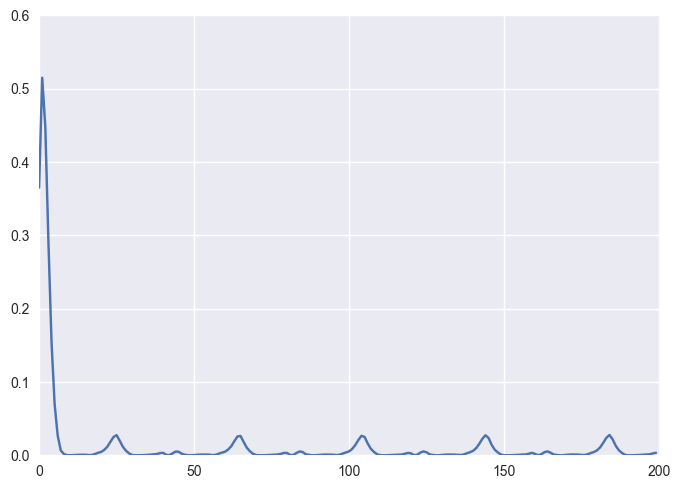

In [6]:
# Plot loss curve
plt.plot(loss_lst)
plt.show()